# RL homework 2
**Due date: 26 February 2018, 23:55am **

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

Do not forget to include the PDF version on the .zip submitted in Moodle.

Also send a sharable link to the notebook at the following email: **`ucl.coursework.submit@gmail.com`**

## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

### A grid world

In [0]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()

### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=0, vmax=10):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  
# If epsilon = 0.1, so 90% return max action value, and 10% return random value 
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

In [5]:
 np.random.randint(np.array([1, 2, 3,4]).shape[-1])

0

# Part 1: Implement agents

Each agent, should implement a step function:

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

In this assignment, observations will be states in the environment, so the agent state, environment state, and observation will overlap, and we will use the word `state` interchangably with `observation`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  In our experiments the helper functions above will just use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```


### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

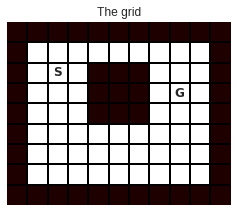

In [6]:
grid = Grid()
grid.plot_grid()

## Random agent

In [0]:
# For reference: here is a random agent
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(number_of_actions)
    return next_action


## Agent 1: TD learning
**[5 pts]** Implement an agent that behaves randomly, but that _on-policy_ estimates state values $v(s)$, using one-step TD learning with a step size $\alpha=0.1$.

Also implement `get_values(self)` that returns the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement `get_values` and `step`.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  Hint: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [0]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    
  def get_values(self):
    """TODO: Implement"""
    return self._values
    

  # Return a new action to take
  # r: reward, g: discount, s: next_observation
  def step(self, r, g, s):
    """TODO: Implement"""
    # Random next action 
    next_action  = np.random.randint(self._number_of_actions)
   
    # Update State Value
    self._values[self._state] += self._step_size * (r + g * self._values[s] - self._values[self._state])
    self._state = s
    return next_action


Run the next cell to run the `RandomTD` agent on a grid world.

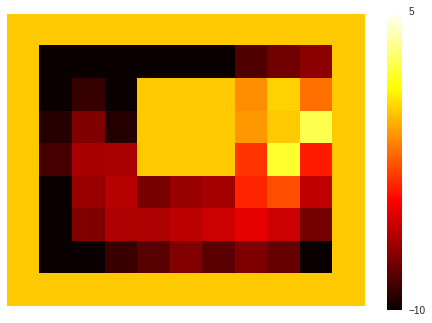

In [42]:
# DO NOT MODIFY THIS CELL
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.get_values()
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

If everything worked as expected, the plot above will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange above).

### Policy iteration
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state the policy would for each action look at the value of the resulting state, and would then pick the action with the highest state value. You do **not** have to implement this, just answer the following questions.

**[5 pts]** Would the greedy after one such iteration of policy evaluation and policy improvement be optimal on this problem?  Explain (in one or two sentences) why or why not.

NO，in one iteration, we can only update current state value via the next state, but there are 4 possible state for updating current state. The one iteration one-step TD learning can not converge to optimal.

**[5 pts]** If we repeat the process over and over again, and repeatedly evaluate the greedy policy and then perform another improvement step, would then the policy eventually become optimal?  Explain (in one or two sentences) why of why not.

Yes. It uses batch updating, under which one-step TD converges deterministically to a single answer independent of the step-size parameter, $\alpha$ as long as $\alpha$ is chosen to be sufficiently small. The batch TD(0) always finds the estimate that would be exactly correct for the maximun-likeihood model of the Markov process so that we can compute the estimate of the value function that would be exactly correct if the model were exactly correct.


## Agent 2: Q-learning
**[10 pts]** Implement an agent that uses **Q-learning** to learn action values.  In addition, the agent should act according to an $\epsilon$-greedy policy with respect to its action values.

**[10 pts]** Include an option to use **Double Q-learning**, with a `double` boolean flag in the **__init__**.  If `double=False` the agent should perform Q-learning.  If `double=True` the agent should perform Double Q-learning.  Note that we then need two action-value functions.

**[10 pts]** Include an option to use **Sarsa** instead of Q-learning, in the **step**.

**[15 pts]** Generalize to **General Q-learning**, where the `__init__` takes a functions `target_policy` and `behaviour_policy`.  The function `behaviour_policy(action_values)` should map `action_values` to a single action.  For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```
We will typically just use $\epsilon$-greedy, for instance:
```
def behaviour_policy(action_values):
  return epsilon_greedy(action_values, epsilon=0.1)
```

The target policy is defined by a function `target_policy(action_values, action)`, which should return **a vector** with one probability per action.  The `action` argument is used to be able to do Sarsa: in addition to the action values, the function will also get the action as selected by the behaviour so that it can return a one hot vector for just the selected action in the Sarsa case.  So, the target policy for Sarsa would look like this:
```
def one_hot(index, max_index):
  np.eye(max_index)[index]

def target_policy(action_values, action):
  return one_hot(action)
```
As another example, a random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

Note that **double learning** can be combined with General Q-learning, but is separate.  So, the `double` flag in the init remains.  E.g., when the target policy is the Sarsa policy described above and `double=True`, the algorithm should implement **double Sarsa**.

Note also that if (or when) you have implemented General Q-learning, this algorithm encompasses all previous algorithms, so you only need this one algorithm with, as its interface the two functions

`__init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1)`

and

`step(self, reward, discount, next_state)`

We will mostly use `step_size=0.1`, so make that the default, but allow it to change when it is fed in as an argument.

If you do not success in implementing General Q-learning, try to implement at least Sarsa, Q-learning, and Double Q-learning, to be able to answer questions below.


In [0]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, target_policy, behaviour_policy, double, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    self._last_action = 0
    
  @property
  def q_values(self):
    if self._double:
      return (self._q + self._q2)/2
    else:
      return self._q
    
  ''' 
  Return a new action to take
  r: reward, 
  g: discount, 
  s: next_state
  '''
  def step(self, r, g, s):
    """TODO Implement"""
    
    # Double Q-learning and SARSA
    if self._double:
      # Use epsilon greedy to get action a，and epsilon greedy in Q1 + Q2
      a = self._behaviour_policy(self._q[s] + self._q2[s])  
      
      # Update State Value
      # WIth 0.5 probability
      if 0.5 < np.random.random():
         self._q[self._s, self._last_action] += self._step_size * (r + g * self._q2[s, np.argmax(self._target_policy(self._q[s], a))] - self._q[self._s, self._last_action])

      else:
         self._q2[self._s, self._last_action] += self._step_size * (r + g * self._q[s, np.argmax(self._target_policy(self._q2[s], a))] - self._q2[self._s, self._last_action])

      self._s = s
      self._last_action = a
      
      return a
    
    # Q-learning/SARSA
    else:
      # Use epsilon greedy to get action a 
      a = self._behaviour_policy(self._q[s])

      # Update State Value
      self._q[self._s, self._last_action] += self._step_size * (r + g * self._q[s, np.argmax(self._target_policy(self._q[s], a))] - self._q[self._s, self._last_action])
      self._s = s
      self._last_action = a
      return a

# Part 2: Analyse Results

### Run the cells below to train a Q-learning and a SARSA agent and generate plots.

This trains the agents the Grid problem with a step size of 0.1 and an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

Q-learning


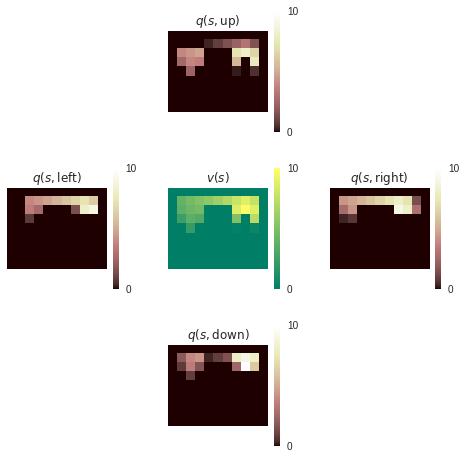

In [36]:
# Q-learning
print('Q-learning')
grid = Grid()
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]
def behaviour_policy(q):
  return epsilon_greedy(q, 0.1)
agent = GeneralQ(grid._layout.size, 4, grid.get_obs(),
                 target_policy, behaviour_policy, double=False)
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

SARSA


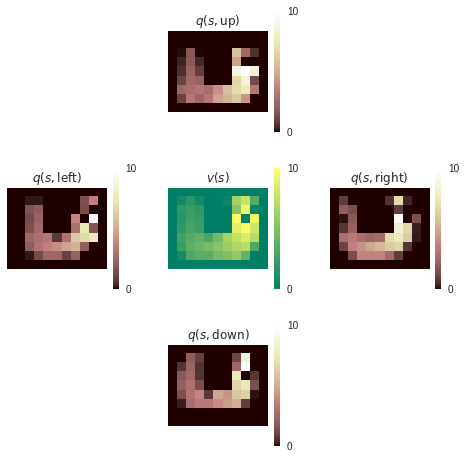

In [37]:
# SARSA
print('SARSA')
grid = Grid()
def target_policy(q, a):
  return np.eye(len(q))[a]
def behaviour_policy(q):
  return epsilon_greedy(q, 0.1)
agent = GeneralQ(grid._layout.size, 4, grid.get_obs(),
                 target_policy, behaviour_policy, double=False)
run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

## Questions

Consider the greedy policy with respect to the estimated values

**[10 pts]** *How* do the policies found by Q-learning and Sarsa differ?  (Explain qualitatively how the behaviour differs in one or two sentences.)

Q-learning is off-policy learning. Because it have $max_a Q(s_{t+1}, a)$ in action value update fucntion, and it always choose the most shortest path to goal, no matter how the rewards in the process. In the figure above, Q-learning choose shorter but moere safe path compared with Q-learning.


Sarsa is on-policy learning. Sarsa is quite conservative, it will choose to stay far away from low rewards. In the figure above, Sarsa choose farther but more dangerous path compared with Q-learning.

**[10 pts]** *Why* do the policies differ in this way?

The biggest difference between Q-learning and SARSA is that Q-learning is off-policy, whereas SARSA is on-policy.

The updated equations for Q-learning and SARSA are below:

$Q-learning: Q(s_t, a_t) = Q(s_t, a_t) + a[r + \gamma max_a Q(s_{t+1}, a)-Q(s_t, a_t)]$

$Sarsa: Q(s_t, a_t) = Q(s_t, a_t) + a[r + \gamma Q(s_{t+1}, a_{t+1})-Q(s_t, a_t)]$

In state $s'$, Q-learning only calculate which $a'$ to take in $s'$ to get bigger Q, and do not really take this action $a'$. The selection of action a is based on the current Q network and the strategy (e-greedy), and the calculation of the target Q value is calculated based on the action $a'$ with the largest Q value. Therefore, it is the off-policy learning

In state $s'$, Sarsa know which $a'$ it want to take and really take this action. The selection of action a follows the e-greedy policy, and the calculation of the target Q value is also calculated according to the action $a'$ obtained by the (e-greedy) policy, thus it is  on-policy learning.

**[10 pts]** Which greedy policy is better, in terms of actual value?

If the goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If your agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.

In the grid environment of this coursework, Q-learning can choose the shorter path, and Sarsa can gain more rewards in the learning process.

### Noisy environments

We will now compare Q-learning and Double Q-learning on a noisy version of the environment.

In the noisy version, a zero-mean Gaussian is added to all rewards.  The variance of this noise is higher the further to the left you go, and the further down (so away from the goal).

Run the cell below to run 20 repetitions of the experiment that runs Q-learning and Double Q-learning on this noisy domain.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


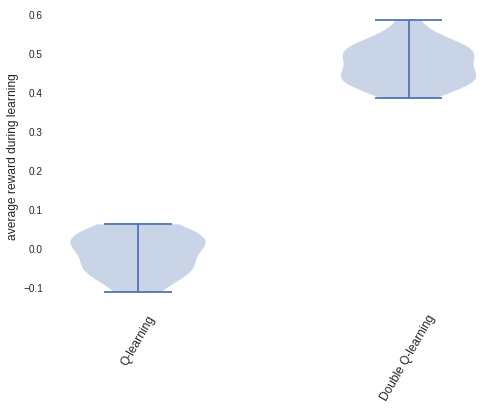

In [33]:
def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)
def behaviour_policy(q):
  return epsilon_greedy(q, 0.1)
mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(20):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(grid._layout.size, 4, grid.get_obs(),
                     target_policy, behaviour_policy, double=False, step_size=0.1)
  dq_agent = GeneralQ(grid._layout.size, 4, grid.get_obs(),
                      target_policy, behaviour_policy, double=True, step_size=0.1)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))
plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.set_axis_bgcolor('white')
ax.grid(0)

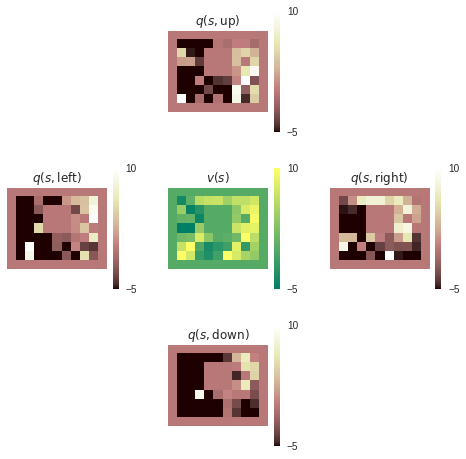

In [34]:
q = q_agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q, vmin=-5)

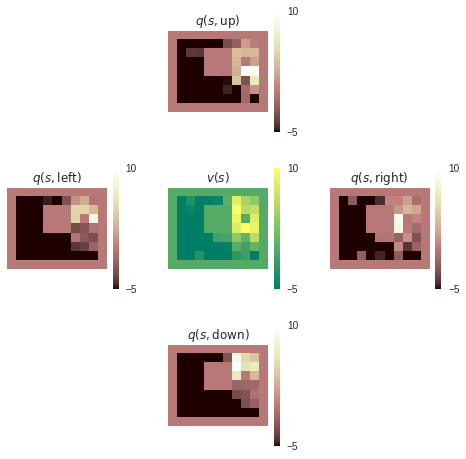

In [35]:
q = dq_agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q, vmin=-5)

The plots above show 1) the distributions of average rewards (over all learning steps) over the 20 experiments per algorithm, 2) the action values for Q-learning, and 3) the action values for Double Q-learning.

**[10 pts]** Explain why Double Q-learning has a higher average reward. Use at most four sentences, and discuss at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the resulting behaviour yields higher rewards for Double Q-learning than for Q-learning.

Because Q-learning use max operator in action value update euqation, and it will cause maximiztion bias problem, and double Q-learning can solve this problem. In the double Q-learning algorithm there are two action-value functions, and we update one of the two value functions by assigning each experience randomly. The goal is to decorrelate the selection of the best action from the evaluation of this action to avoid maximiztion bias problem, so double Q-learning have higher average reward.

(Feel free to experiment to gain more intuition, if this is helpful.  Especially the action value plots can be quite noisy, and therefore hard to interpret.)